In [1]:
import math
import numpy as np
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle
import networkx as nx
from itertools import chain
import traitlets as T
import ipywidgets as W
from ipyradiant import LoadWidget
from rdflib import BNode, Graph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph

In [2]:
lw = LoadWidget()

In [3]:
lw

LoadWidget(children=(LoadBox(children=(Label(value='Click to load file:'), FileUpload(value={}, accept='.rdf,.…

In [4]:
rdf_graph = lw.graph

In [5]:
netx_graph = rdflib_to_networkx_graph(rdf_graph)

In [6]:
cvsopts = dict(plot_height=400, plot_width=400)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

In [7]:
def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)
    
def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
        
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)

In [8]:
def ng(graph,name):
    graph.name = name
    return graph

def nx_layout(graph):
    layout = nx.circular_layout(graph)
    data = [[node]+layout[node].tolist() for node in graph.nodes]

    nodes = pd.DataFrame(data, columns=['id', 'x', 'y'])
    nodes.set_index('id', inplace=True)

    edges = pd.DataFrame(list(graph.edges), columns=['source', 'target'])
    return nodes, edges

def nx_plot(graph, name=""):
    #print(graph.name, len(graph.edges))
    nodes, edges = nx_layout(graph)
    
    direct = connect_edges(nodes, edges)


    return [graphplot(nodes, direct, graph.name)]

In [9]:

plot = [nx_plot(netx_graph, name='tailsitter network')]
print(*chain.from_iterable(plot))

<xarray.Image '' (y: 400, x: 400)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
Coordinates:
  * x        (x) float64 -0.9975 -0.9925 -0.9875 ... 0.9875 0.9925 0.9975
  * y        (y) float64 -0.9975 -0.9925 -0.9875 ... 0.9875 0.9925 0.9975


""

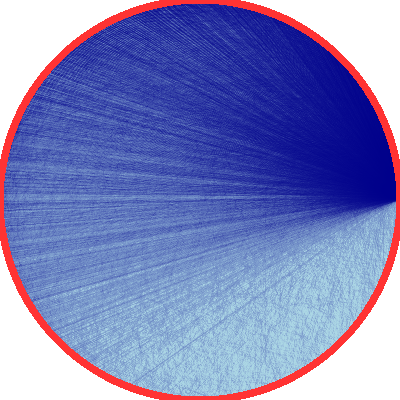

In [10]:
tf.Images(*chain.from_iterable(plot)).cols(3)